In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

In [3]:
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

### 고객 정보 중심으로 탐색
- 지역별 구매자 수 / 주문 수
- 지역별 주문 1건당 평균 결제 금액
- 배송 지연 시 저평점 전환율 (지역 단위)

In [11]:
# EDA에 사용할 DataFrame 만들기
customer_df = (
    orders
    .merge(customers, on="customer_id", how="left")
)

# 결제 정보
payment_agg = (
    order_payments
    .groupby("order_id", as_index=False)
    .agg(payment_value=("payment_value", "sum"))
)

customer_df = customer_df.merge(
    payment_agg,
    on="order_id",
    how="left"
)

# 배송 지연 여부
# datetime 변환
customer_df["order_purchase_timestamp"] = pd.to_datetime(
    customer_df["order_purchase_timestamp"]
)
customer_df["order_delivered_customer_date"] = pd.to_datetime(
    customer_df["order_delivered_customer_date"]
)
customer_df["order_estimated_delivery_date"] = pd.to_datetime(
    customer_df["order_estimated_delivery_date"]
)

# 배송 지연 여부
customer_df["is_delayed"] = (
    customer_df["order_delivered_customer_date"]
    > customer_df["order_estimated_delivery_date"]
)

# 리뷰 join 
customer_df = customer_df.merge(
    order_reviews[["order_id", "review_score"]],
    on="order_id",
    how="left"
)

customer_df["is_low_review"] = customer_df["review_score"] <= 2

# 첫구매 / 재구매 여부
first_order = (
    customer_df
    .groupby("customer_unique_id")["order_purchase_timestamp"]
    .min()
    .reset_index()
    .rename(columns={"order_purchase_timestamp": "first_order_date"})
)

customer_df = customer_df.merge(
    first_order,
    on="customer_unique_id",
    how="left"
)

customer_df["is_first_purchase"] = (
    customer_df["order_purchase_timestamp"]
    == customer_df["first_order_date"]
)

In [13]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99992 non-null  object        
 1   customer_id                    99992 non-null  object        
 2   order_status                   99992 non-null  object        
 3   order_purchase_timestamp       99992 non-null  datetime64[ns]
 4   order_approved_at              99831 non-null  object        
 5   order_delivered_carrier_date   98199 non-null  object        
 6   order_delivered_customer_date  97005 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99992 non-null  datetime64[ns]
 8   customer_unique_id             99992 non-null  object        
 9   customer_zip_code_prefix       99992 non-null  int64         
 10  customer_city                  99992 non-null  object        
 11  customer_state 

In [14]:
# 지역별 구매자 수
region_summary = (
    customer_df
    .groupby("customer_state")
    .agg(
        buyers=("customer_unique_id", "nunique"),  # 구매자 수
        orders=("order_id", "nunique")              # 주문 수
    )
    .reset_index()
    .sort_values("orders", ascending=False)
)

region_summary.head()

,customer_state,buyers,orders
25,SP,40302,41746
18,RJ,12384,12852
10,MG,11259,11635
22,RS,5277,5466
17,PR,4882,5045


In [16]:
# 지역별 주문 수 대비 구매자 수
region_summary["orders_per_buyer"] = (
    region_summary["orders"] / region_summary["buyers"]
)

region_summary.sort_values("orders_per_buyer", ascending=False).head()

,customer_state,buyers,orders,orders_per_buyer
20,RO,240,253,1.054167
0,AC,77,81,1.051948
18,RJ,12384,12852,1.037791
25,SP,40302,41746,1.035829
22,RS,5277,5466,1.035816


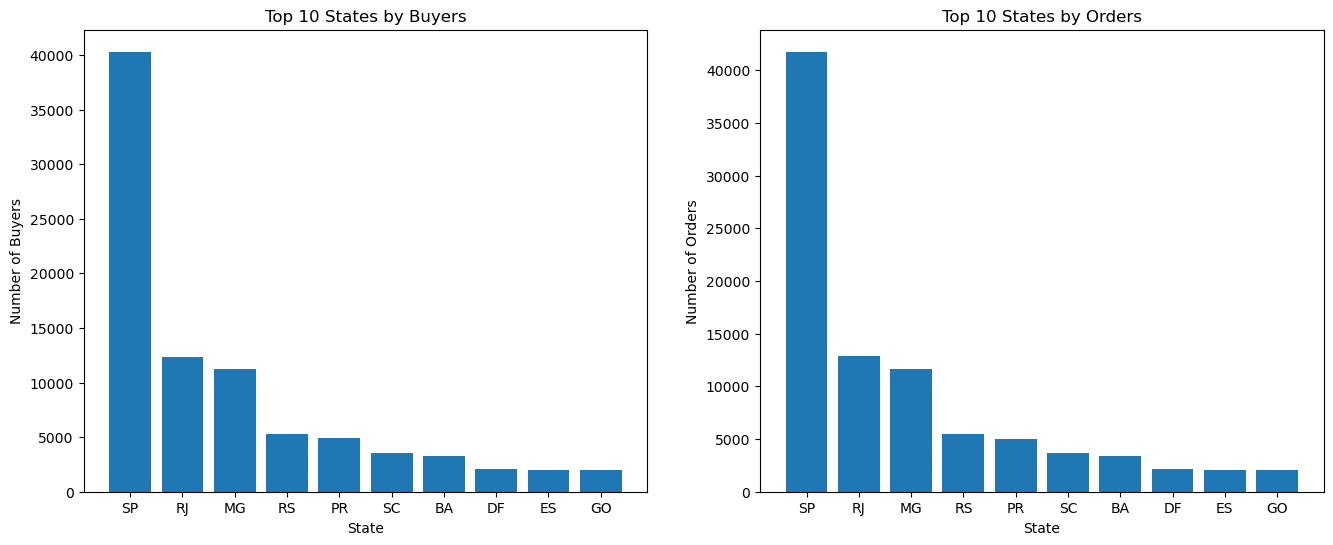

In [19]:
top10 = (
    region_summary
    .sort_values("orders", ascending=False)
    .head(10)
)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].bar(top10["customer_state"], top10["buyers"])
axes[0].set_title("Top 10 States by Buyers")
axes[0].set_xlabel("State")
axes[0].set_ylabel("Number of Buyers")

axes[1].bar(top10["customer_state"], top10["orders"])
axes[1].set_title("Top 10 States by Orders")
axes[1].set_xlabel("State")
axes[1].set_ylabel("Number of Orders")

plt.show()

- 상위 10개 주의 구매자 수와 주문 수가 비례하는 것으로 보임

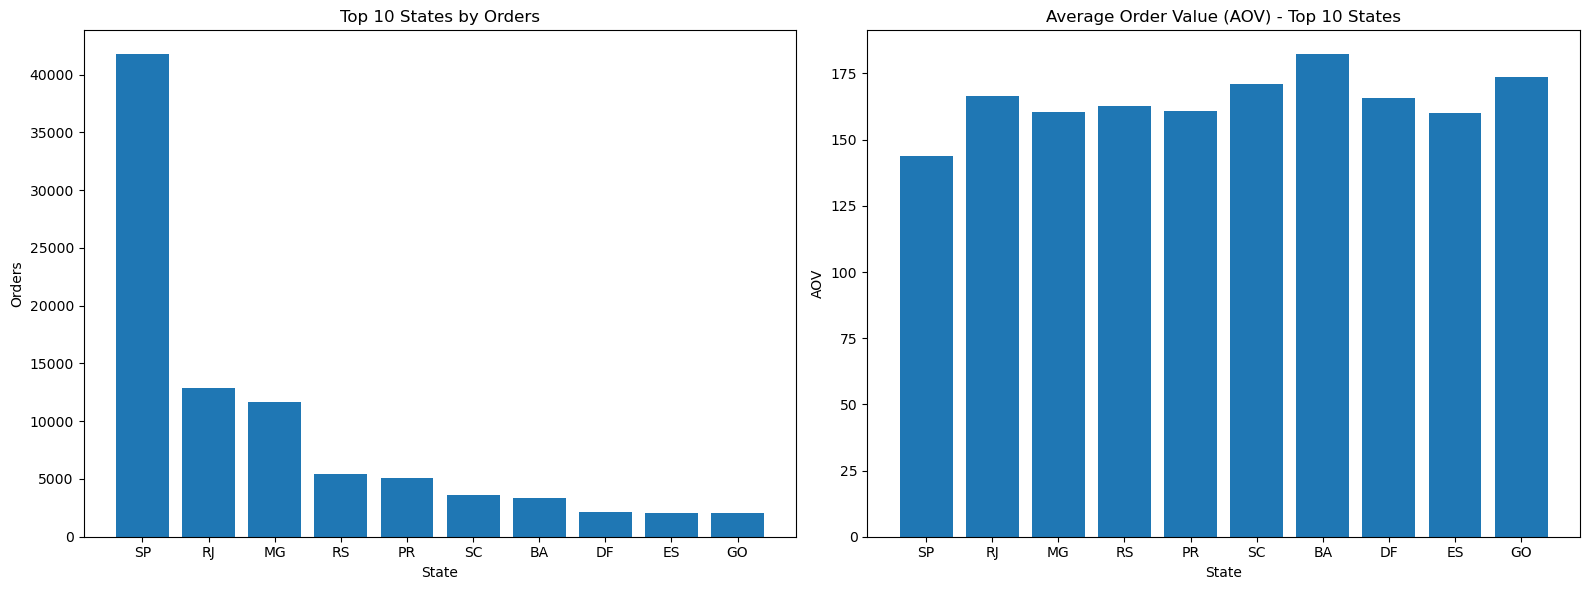

In [21]:
# Average Order Value 계산
top10_states = top10["customer_state"]

top10_aov = (
    customer_df[customer_df["customer_state"].isin(top10_states)]
    .groupby("customer_state")
    .agg(aov=("payment_value", "mean"))
    .reset_index()
)

# 주문 수 기준 정렬 순서 맞추기
top10_aov = top10_aov.set_index("customer_state").loc[top10_states].reset_index()


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].bar(top10["customer_state"], top10["orders"])
axes[0].set_title("Top 10 States by Orders")
axes[0].set_xlabel("State")
axes[0].set_ylabel("Orders")

axes[1].bar(top10_aov["customer_state"], top10_aov["aov"])
axes[1].set_title("Average Order Value (AOV) - Top 10 States")
axes[1].set_xlabel("State")
axes[1].set_ylabel("AOV")

plt.tight_layout()
plt.show()

- SP가 주문수는 압도적으로 많지만, 주문 1건당 평균 결제 금액은 상대적으로 낮은 것으로 보임
- 그에 반해 BA는 주문수 상위 10개 안에는 없지만, 가장 높은 AOV를 보임
- 주문수와 AOV가 균형을 이루는 지역은 RJ와 MG지만, SP가 주문수가 압도적으로 높음

In [25]:
# 배송 지연 시 저평점(1-2점) 전환율 (지역 단위)
# 전환율 = (배송지연 & 저평점 주문 수 ) / 비송 지연 주문 수

delay_to_low_review = (
    customer_df[customer_df["is_delayed"]]
    .groupby("customer_state")
    .agg(
        delayed_orders=("order_id", "nunique"),
        low_review_orders=("is_low_review", "sum")
    )
    .reset_index()
)

delay_to_low_review["delay_to_low_review_rate"] = (
    delay_to_low_review["low_review_orders"]
    / delay_to_low_review["delayed_orders"]
)

delay_to_low_review.sort_values(
    "delay_to_low_review_rate",
    ascending=False
).head()

,customer_state,delayed_orders,low_review_orders,delay_to_low_review_rate
21,RR,5,4,0.800000
0,AC,3,2,0.666667
24,SE,51,34,0.666667
18,RJ,1664,1093,0.656851
19,RN,51,33,0.647059


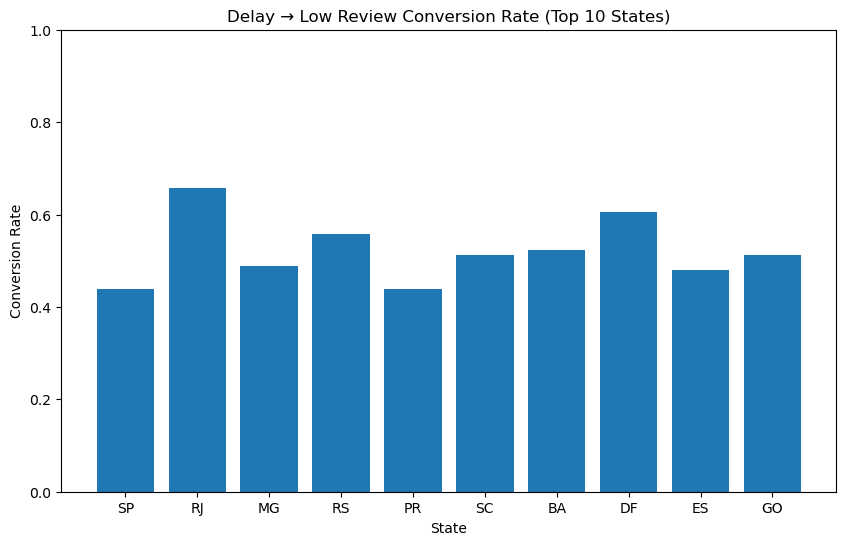

In [26]:
# 상위 10개 필터
delay_to_low_review_top10 = (
    delay_to_low_review
    .set_index("customer_state")
    .loc[top10["customer_state"]]
    .reset_index()
)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(
    delay_to_low_review_top10["customer_state"],
    delay_to_low_review_top10["delay_to_low_review_rate"]
)
plt.title("Delay → Low Review Conversion Rate (Top 10 States)")
plt.xlabel("State")
plt.ylabel("Conversion Rate")
plt.ylim(0, 1)

plt.show()

- cs, 운영 리스크를 확인하는 지표
- 전환율 높은 지역일 수록 배송 문제가 있을 경우 즉각적인 불만이 나와 초기 진입 시 CS 리스크가 큼

### 상품 중심으로 탐색
- 카테고리별 주문 수 / 매출 비중
- 배송 지연 시 저평점 전환율 (카테고리 기준)

In [30]:
# dataframe 만들기
category_df = (
    order_items
    .merge(products, on="product_id", how="left")
    .merge(category_translation, on="product_category_name", how="left")
)

# 카테고리별 주문 수
category_orders = (
    category_df
    .groupby("product_category_name_english")
    .agg(
        order_count=("order_id", "nunique"),
        item_count=("product_id", "count")
    )
    .reset_index()
)

# 카테고리별 매출
category_revenue = (
    category_df
    .groupby("product_category_name_english")
    .agg(
        revenue=("price", "sum")
    )
    .reset_index()
)

# 주문 수 / 매출 통합 + 비중 계산
category_summary = (
    category_orders
    .merge(category_revenue, on="product_category_name_english", how="left")
)

# 전체 대비 비중
category_summary["order_share"] = (
    category_summary["order_count"]
    / category_summary["order_count"].sum()
)

category_summary["revenue_share"] = (
    category_summary["revenue"]
    / category_summary["revenue"].sum()
)

category_summary = category_summary.sort_values(
    "order_count", ascending=False
)

category_summary.head(30)

,product_category_name_english,order_count,item_count,revenue,order_share,revenue_share
7,bed_bath_table,9417,11115,1036988.68,0.096095,0.077349
43,health_beauty,8836,9670,1258681.34,0.090166,0.093885
65,sports_leisure,7720,8641,988048.97,0.078778,0.073699
15,computers_accessories,6689,7827,911954.32,0.068257,0.068023
39,furniture_decor,6449,8334,729762.49,0.065808,0.054433
49,housewares,5884,6964,632248.66,0.060043,0.047160
70,watches_gifts,5624,5991,1205005.68,0.057390,0.089882
68,telephony,4199,4545,323667.53,0.042848,0.024142
5,auto,3897,4235,592720.11,0.039767,0.044211
69,toys,3886,4117,483946.60,0.039654,0.036098


In [51]:
top20_categories = (
    category_summary
    .sort_values("order_count", ascending=False)
    .head(20)
    .reset_index(drop=True)
)

top30_categories

,product_category_name_english,order_count,item_count,revenue,order_share,revenue_share
0,bed_bath_table,9417,11115,1036988.68,0.096095,0.077349
1,health_beauty,8836,9670,1258681.34,0.090166,0.093885
2,sports_leisure,7720,8641,988048.97,0.078778,0.073699
3,computers_accessories,6689,7827,911954.32,0.068257,0.068023
4,furniture_decor,6449,8334,729762.49,0.065808,0.054433
5,housewares,5884,6964,632248.66,0.060043,0.047160
6,watches_gifts,5624,5991,1205005.68,0.057390,0.089882
7,telephony,4199,4545,323667.53,0.042848,0.024142
8,auto,3897,4235,592720.11,0.039767,0.044211
9,toys,3886,4117,483946.60,0.039654,0.036098


In [52]:
top20_categories[["order_share", "revenue_share"]].sum()

order_share      0.883374
revenue_share    0.841692
dtype: float64

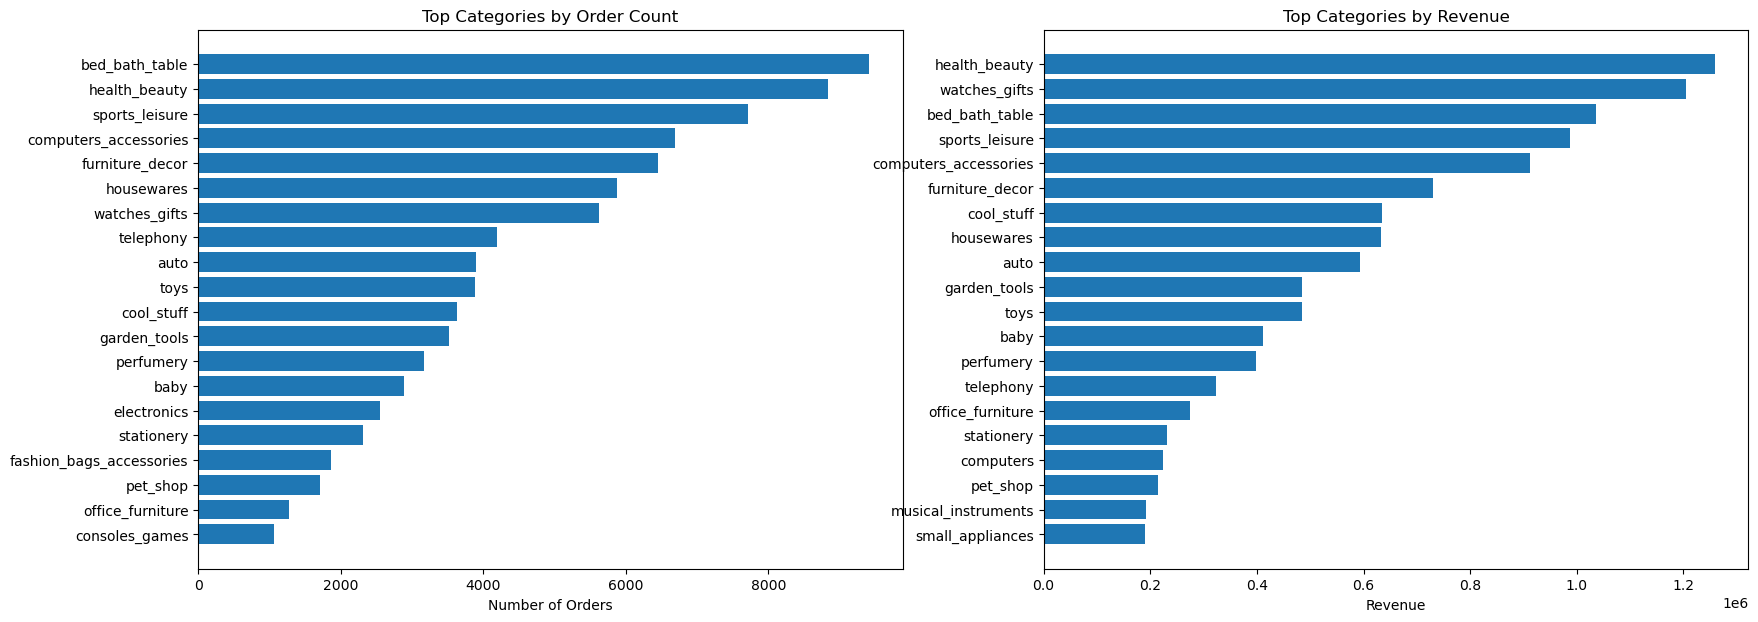

In [53]:
# 판매 수량과 매출 기준 그래프

TOP_N = 20

top_order = category_summary.sort_values(
    "order_count", ascending=False
).head(TOP_N)

top_revenue = category_summary.sort_values(
    "revenue", ascending=False
).head(TOP_N)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

# 주문 수 기준
axes[0].barh(
    top_order["product_category_name_english"],
    top_order["order_count"]
)
axes[0].set_title("Top Categories by Order Count")
axes[0].set_xlabel("Number of Orders")
axes[0].invert_yaxis()  # 가장 큰 값이 위로 오게

# 매출 기준
axes[1].barh(
    top_revenue["product_category_name_english"],
    top_revenue["revenue"]
)
axes[1].set_title("Top Categories by Revenue")
axes[1].set_xlabel("Revenue")
axes[1].invert_yaxis()

plt.show()

- bed_bath_table이 판매량은 1위지만, 매출은 3위 기록
- health_beauty 제품은 판매량은 2위지만, 매출은 1위 기록
- health_beauty 시장에서 한국 제품의 이미지가 좋을 것으로 예상

In [36]:
# 배송 지연 시 저평점(1-2점) 전환율 (카테고리 기준)
# 전환율 = (배송지연 & 저평점 주문 수) / 배송 지연 주문 수

# 위 데이터에서 상위권 카테고리만 몇개 추출
target_categories = [
    "bed_bath_table",
    "health_beauty",
    "sports_leisure",
    "computers_accessories",
    "watches_gifts"
]

# 해당 카테고리만 필터링
target_df = category_delay_df[
    category_delay_df["product_category_name_english"].isin(target_categories)
]

# 전체 카테고리 기준 평균 전환율
overall_avg_rate = (
    category_delay_df[category_delay_df["is_delayed"]]["is_low_review"].mean()
)

overall_avg_rate

# 카테고리별 배송 지연 -> 저평점 전환율 계산
target_delay_rate = (
    target_df[target_df["is_delayed"]]
    .groupby("product_category_name_english")
    .agg(
        delayed_orders=("order_id", "nunique"),
        low_review_orders=("is_low_review", "sum")
    )
    .reset_index()
)

target_delay_rate["delay_to_low_review_rate"] = (
    target_delay_rate["low_review_orders"]
    / target_delay_rate["delayed_orders"]
)

target_delay_rate

,product_category_name_english,delayed_orders,low_review_orders,delay_to_low_review_rate
0,bed_bath_table,811,512,0.631319
1,computers_accessories,503,315,0.626243
2,health_beauty,776,450,0.579897
3,sports_leisure,584,345,0.590753
4,watches_gifts,468,274,0.585470


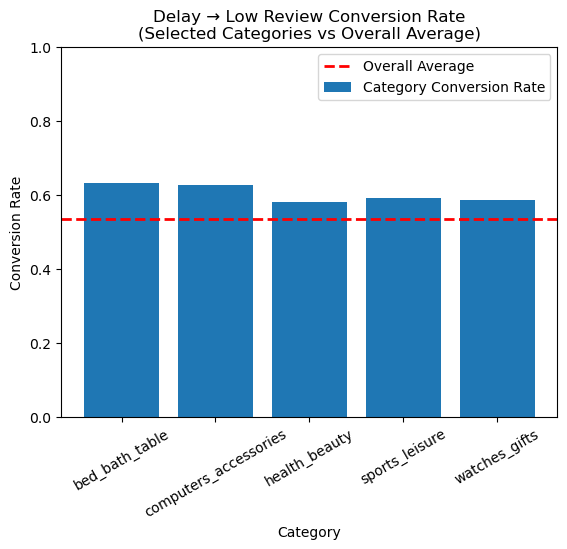

In [37]:
# 카테고리별 전환율
plt.bar(
    target_delay_rate["product_category_name_english"],
    target_delay_rate["delay_to_low_review_rate"],
    label="Category Conversion Rate"
)

# 전체 평균선
plt.axhline(
    y=overall_avg_rate,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Overall Average"
)

plt.title("Delay → Low Review Conversion Rate\n(Selected Categories vs Overall Average)")
plt.xlabel("Category")
plt.ylabel("Conversion Rate")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.legend()
plt.show()

- 확실히 주문수가 많은 제품이 민감도가 평균보다 높음을 알 수 있음
- heath_beauty 제품이 상위 5개 카테고리에서는 가장 낮음

### 판매자 중심으로 탐색
- 지역별 셀러 수
- 카테고리별 셀러 수
- 주문 수 / 셀러 수 (경쟁 강도 proxy)
- 지역 × 카테고리 셀러 밀집도

In [38]:
# datafrmae 구성
seller_category_df = (
    order_items
    .merge(products, on="product_id", how="left")
    .merge(category_translation, on="product_category_name", how="left")
    .merge(sellers, on="seller_id", how="left")
)

# 지역, 카테고리별 셀러 수 집계
seller_count = (
    seller_category_df
    .drop_duplicates(
        subset=["seller_id", "seller_state", "product_category_name_english"]
    )
    .groupby(["seller_state", "product_category_name_english"])
    .agg(
        seller_count=("seller_id", "nunique")
    )
    .reset_index()
)

seller_count.head()

,seller_state,product_category_name_english,seller_count
0,AC,books_technical,1
1,AM,telephony,1
2,BA,baby,1
3,BA,computers,2
4,BA,computers_accessories,4


In [57]:
focus_states = ["SP", "RJ", "MG", "RS", "PR", "SC", "BA", "DF", "ES", "GO"]

top20_categories = (
    category_summary
    .sort_values("order_count", ascending=False)
    .head(20)["product_category_name_english"]
    .tolist()
)

# 지역 + 상위 20개 카테고리로 필터링
seller_count_focus = seller_count[
    (seller_count["seller_state"].isin(focus_states)) &
    (seller_count["product_category_name_english"].isin(top20_categories))
]

# 히트맵용 pivot table 
pivot_seller = seller_count_focus.pivot(
    index="seller_state",
    columns="product_category_name_english",
    values="seller_count"
).fillna(0)

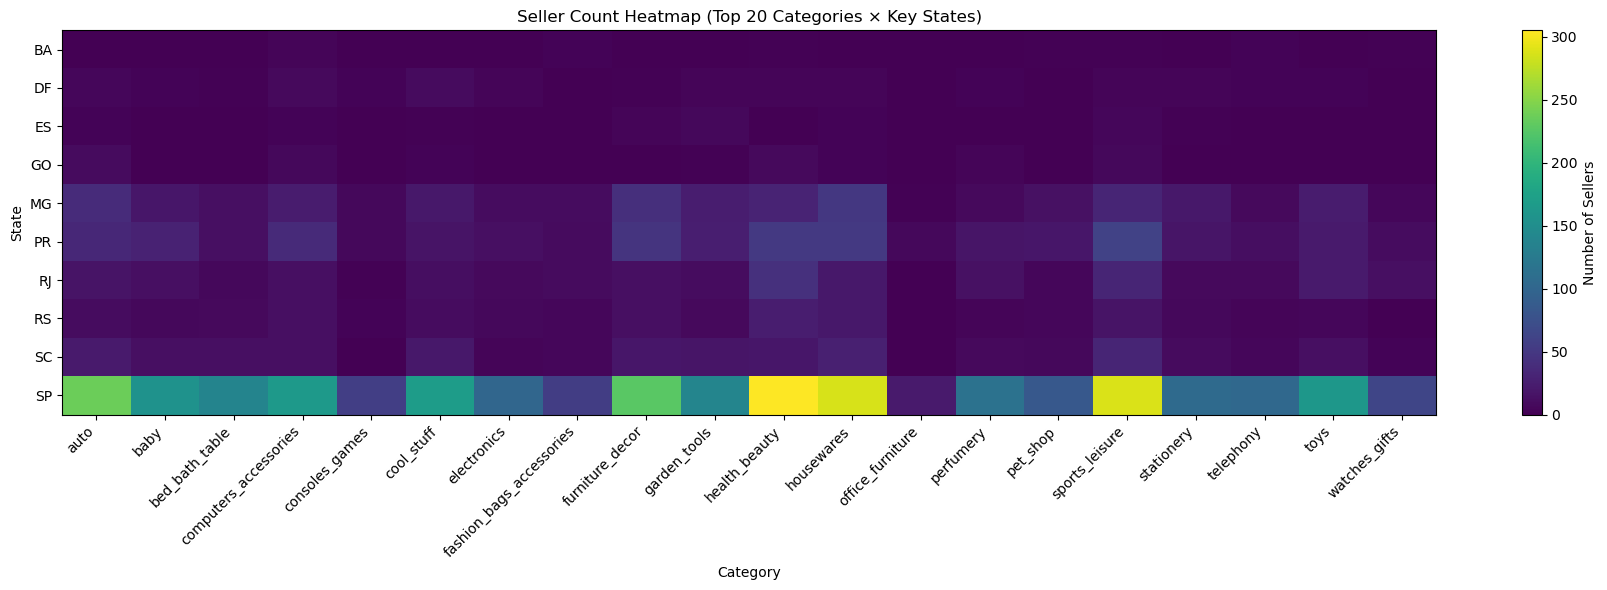

In [58]:

plt.figure(figsize=(18, 6))
plt.imshow(pivot_seller, aspect="auto")
plt.colorbar(label="Number of Sellers")

plt.xticks(
    ticks=range(len(pivot_seller.columns)),
    labels=pivot_seller.columns,
    rotation=45,
    ha="right"
)
plt.yticks(
    ticks=range(len(pivot_seller.index)),
    labels=pivot_seller.index
)

plt.title("Seller Count Heatmap (Top 20 Categories × Key States)")
plt.xlabel("Category")
plt.ylabel("State")

plt.tight_layout()
plt.show()

- health_beauty 시장이 경쟁 과밀 상태임